# USD-ADS 505 TEAM 4 Term Deposit Project

    Katie Hu, Juliet Sieland-Harris, Dingyi Duan

## Import Libraries and Data Set

In [1]:

#Import Libraries

import pandas as pd
import math
import matplotlib.pylab as plt
import numpy as np
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import Data Set

bank = pd.read_csv('D:/USD-ADS_graduate/ADS-505/ADS505 Final Project/Dataset/bank.csv', sep=';')
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


       1 - age (numeric)
       2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services") 
       3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
       4 - education (categorical: "unknown","secondary","primary","tertiary")
       5 - default: has credit in default? (binary: "yes","no")
       6 - balance: average yearly balance, in euros (numeric) 
       7 - housing: has housing loan? (binary: "yes","no")
       8 - loan: has personal loan? (binary: "yes","no")
       9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
      10 - day: last contact day of the month (numeric)
      11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
      12 - duration: last contact duration, in seconds (numeric)
      13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
      14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
      15 - previous: number of contacts performed before this campaign and for this client (numeric)
      16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

      Output variable (desired target):
      17 - y - has the client subscribed a term deposit? (binary: "yes","no")

## EDA

In [3]:
#Find Number of Columns and Rows in Data Set

bank.shape

(4521, 17)

In [4]:
#Find Type of Variables

bank.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [5]:
#Descriptive Statistics

bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [6]:
#Find any missing values

bank.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

    No missing or null values, OK.

In [7]:
# check positive response

print((bank['y'] == 'yes').sum())

# check for response rate

print(100*(bank['y'] == 'yes').sum() / len(bank))

521
11.523999115239992


    Slightly imblanced dataset, but OK

## Preprocessing

### Change binary variables to "0" and "1"

In [8]:
# convert 'y' from 'yes' and 'no' to '1' and '0'
bank['y'] = bank['y'].map(dict(yes=1, no=0))

# convert 'default' from 'yes' and 'no' to '1' and '0'
bank['default'] = bank['default'].map(dict(yes=1, no=0))

# convert 'housing' from 'yes' and 'no' to '1' and '0'
bank['housing'] = bank['housing'].map(dict(yes=1, no=0))

# convert 'load' from 'yes' and 'no' to '1' and '0'
bank['loan'] = bank['loan'].map(dict(yes=1, no=0))

# check for the positive response
print(bank['y'].tolist().count(1))

bank.head()

521


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,0,4789,1,1,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,0,1350,1,0,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,-1,0,unknown,0


### Normalized Bar Charts for the categorical variables

<AxesSubplot:xlabel='marital'>

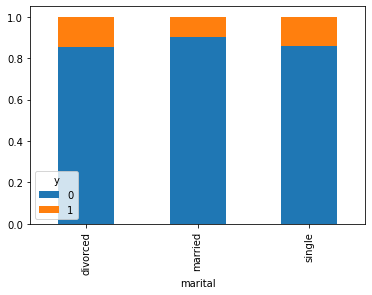

In [9]:
crosstab_marital = pd.crosstab(bank['marital'], bank['y'])
crosstab_marital_norm = crosstab_marital.div(crosstab_marital.sum(axis=1), axis = 0)
crosstab_marital_norm.plot(kind='bar', stacked = True)

<AxesSubplot:xlabel='education'>

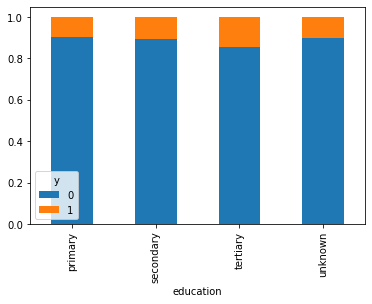

In [10]:
crosstab_education = pd.crosstab(bank['education'], bank['y'])
crosstab_education_norm = crosstab_education.div(crosstab_education.sum(axis=1), axis = 0)
crosstab_education_norm.plot(kind='bar', stacked = True)

<AxesSubplot:xlabel='default'>

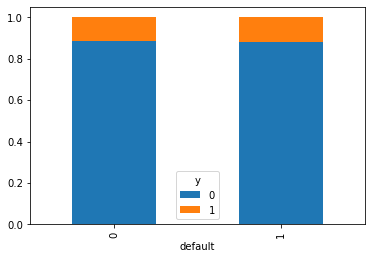

In [11]:
crosstab_default = pd.crosstab(bank['default'], bank['y'])
crosstab_default_norm = crosstab_default.div(crosstab_default.sum(axis=1), axis = 0)
crosstab_default_norm.plot(kind='bar', stacked = True)

<AxesSubplot:xlabel='housing'>

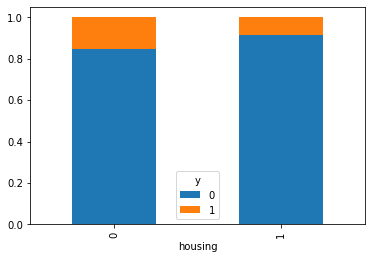

In [12]:
crosstab_housing = pd.crosstab(bank['housing'], bank['y'])
crosstab_housing_norm = crosstab_housing.div(crosstab_housing.sum(axis=1), axis = 0)
crosstab_housing_norm.plot(kind='bar', stacked = True)

<AxesSubplot:xlabel='loan'>

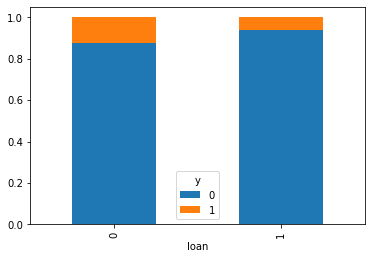

In [13]:
crosstab_loan = pd.crosstab(bank['loan'], bank['y'])
crosstab_loan_norm = crosstab_loan.div(crosstab_loan.sum(axis=1), axis = 0)
crosstab_loan_norm.plot(kind='bar', stacked = True)

<AxesSubplot:xlabel='contact'>

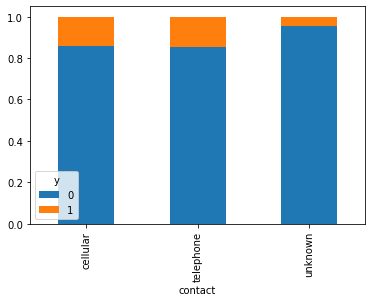

In [14]:
crosstab_contact = pd.crosstab(bank['contact'], bank['y'])
crosstab_contact_norm = crosstab_contact.div(crosstab_contact.sum(axis=1), axis = 0)
crosstab_contact_norm.plot(kind='bar', stacked = True)

<AxesSubplot:xlabel='day'>

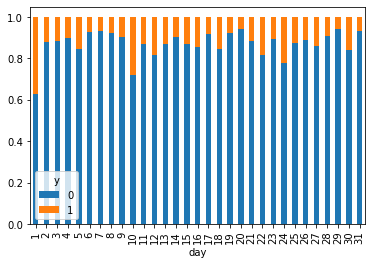

In [15]:
crosstab_day = pd.crosstab(bank['day'], bank['y'])
crosstab_day_norm = crosstab_day.div(crosstab_day.sum(axis=1), axis = 0)
crosstab_day_norm.plot(kind='bar', stacked = True)

<AxesSubplot:xlabel='month'>

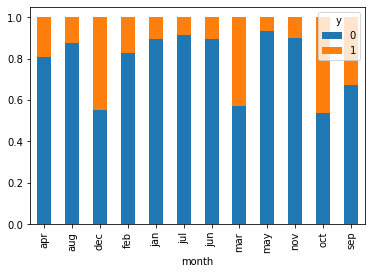

In [16]:
crosstab_month = pd.crosstab(bank['month'], bank['y'])
crosstab_month_norm = crosstab_month.div(crosstab_month.sum(axis=1), axis = 0)
crosstab_month_norm.plot(kind='bar', stacked = True)

<AxesSubplot:xlabel='pdays'>

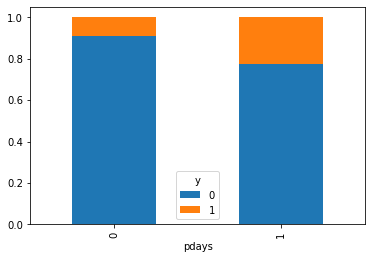

In [17]:
# convert 'pdays' to '0' as 'Never contacted since last campaign' and '1' as 'Contacted'
b = [-1,0,99999]
l = ['0','1']

bank['pdays'].astype(int)
bank['pdays'] = pd.cut(bank['pdays'], bins=b, labels=l, include_lowest=True)

crosstab_pdays = pd.crosstab(bank['pdays'], bank['y'])
crosstab_pdays_norm = crosstab_pdays.div(crosstab_pdays.sum(axis=1), axis = 0)
crosstab_pdays_norm.plot(kind='bar', stacked = True)

<AxesSubplot:xlabel='poutcome'>

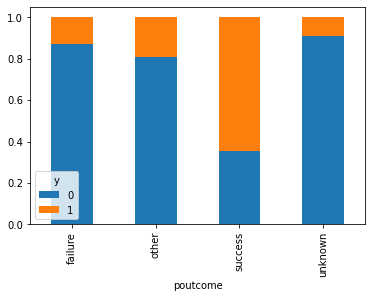

In [18]:
crosstab_poutcome = pd.crosstab(bank['poutcome'], bank['y'])
crosstab_poutcome_norm = crosstab_poutcome.div(crosstab_poutcome.sum(axis=1), axis = 0)
crosstab_poutcome_norm.plot(kind='bar', stacked = True)

<AxesSubplot:xlabel='job'>

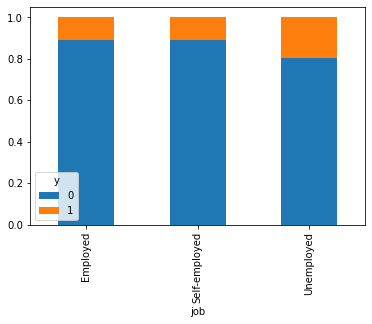

In [19]:
bank['job'] = bank['job'].replace({'management': 'Employed', 'blue-collar': 'Employed',
                                 'technician': 'Employed', 'admin.': 'Employed',
                                 'services': 'Employed', 'retired': 'Unemployed',
                                 'self-employed': 'Self-employed', 'entrepreneur':'Employed',
                                 'unemployed': 'Unemployed', 'housemaid': 'Employed',
                                 'student': 'Unemployed', 'unknown': 'Employed'})

crosstab_job = pd.crosstab(bank['job'], bank['y'])
crosstab_job_norm = crosstab_job.div(crosstab_job.sum(axis=1), axis = 0)
crosstab_job_norm.plot(kind='bar', stacked = True)

### Change 'day' to '0' and '1' for 'Firstdayofmonth'

<AxesSubplot:xlabel='day'>

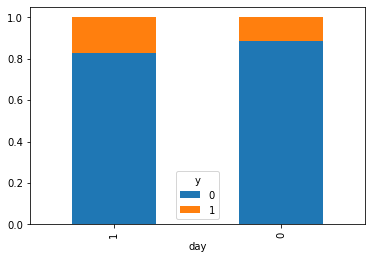

In [20]:
b_day = [1,2,999]
l_day = ['1','0']

bank["day"] = pd.to_numeric(bank["day"])

bank['day'] = pd.cut(bank['day'], bins=b_day, labels=l_day, include_lowest=True)

crosstab_day = pd.crosstab(bank['day'], bank['y'])
crosstab_day_norm = crosstab_day.div(crosstab_day.sum(axis=1), axis = 0)
crosstab_day_norm.plot(kind='bar', stacked = True)

### Change 'education' from categorical to ordinal

<AxesSubplot:xlabel='education'>

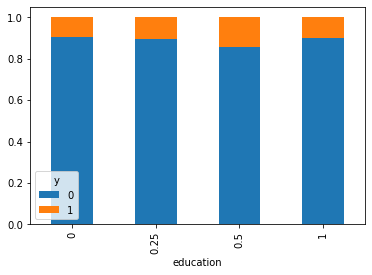

In [21]:
bank['education'] = bank['education'].replace({'primary': '0',
                                              'secondary':'0.25',
                                              'tertiary':'0.5',
                                              'unknown':'1'})
bank['education'].astype(float)
crosstab_education = pd.crosstab(bank['education'], bank['y'])
crosstab_education_norm = crosstab_education.div(crosstab_education.sum(axis=1), axis = 0)
crosstab_education_norm.plot(kind='bar', stacked = True)

### Change 'contact' and 'poutcome' to norminal

In [22]:
bank['contact'] = bank['contact'].replace({'cellular': '0',
                                           'telephone':'1',
                                           'unknown':'2'
                                  })

bank['poutcome'] = bank['poutcome'].replace({'failure': '0',
                                             'other':'1',
                                             'success':'2',
                                             'unknown':'3'
                                  })

### Change 'age' to categorical of 'Youth', 'Adult', 'Senior' and then '0', '1', '2'

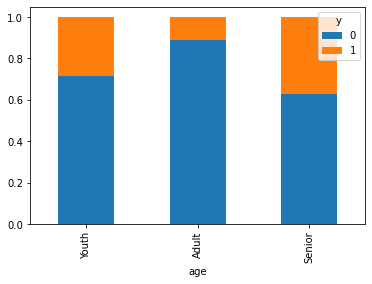

In [23]:
b_age = [0,21,65,99999]
l_age = ['Youth','Adult','Senior']

bank['age'] = pd.cut(bank['age'], bins=b_age, labels=l_age, include_lowest=True)

crosstab_age = pd.crosstab(bank['age'], bank['y'])
crosstab_age_norm = crosstab_age.div(crosstab_age.sum(axis=1), axis = 0)
crosstab_age_norm.plot(kind='bar', stacked = True)

# convert the categories into numbers
bank['age'] = bank['age'].replace({'Youth': '0',
                                   'Adult':'1',
                                   'Senior':'2'
                                  })

### Change 'month' to norminal

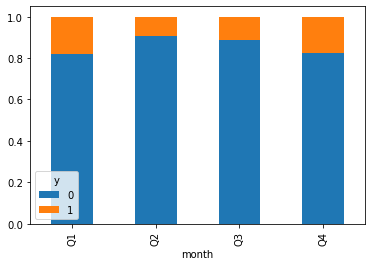

In [24]:
bank['month'] = bank['month'].replace({'jan': '1','feb':'2','mar':'3','apr':'4','may':'5',
                                       'jun':'6','jul':'7','aug':'8','sep':'9','oct':'10',
                                       'nov':'11','dec':'12'
                                  })

bank["month"] = pd.to_numeric(bank["month"])

b_month = [0,3,6,9,12]
l_month = ['Q1','Q2','Q3','Q4']

bank['month'] = pd.cut(bank['month'], bins=b_month, labels=l_month, include_lowest=True)

crosstab_month = pd.crosstab(bank['month'], bank['y'])
crosstab_month_norm = crosstab_month.div(crosstab_month.sum(axis=1), axis = 0)
crosstab_month_norm.plot(kind='bar', stacked = True)

bank['month'] = bank['month'].replace({'Q1': '1',
                                       'Q2':'2',
                                       'Q3':'3',
                                       'Q4':'4'
                                            })

### Create dummy variables for the categorical features

In [25]:
# create dummy variables for categorical features

cat_df = bank[['job','marital']]
dummy_df = pd.get_dummies(cat_df)

# merge dummy variables to the original bank

bank = pd.concat([bank, dummy_df], axis=1)  

# drop the original categorical features

bank = bank.drop(['job','marital'], axis = 1)

bank.head()

,age,education,default,balance,housing,loan,contact,day,month,duration,...,pdays,previous,poutcome,y,job_Employed,job_Self-employed,job_Unemployed,marital_divorced,marital_married,marital_single
0,1,0,0,1787,0,0,0,0,4,79,...,0,0,3,0,0,0,1,0,1,0
1,1,0.25,0,4789,1,1,0,0,2,220,...,1,4,0,0,1,0,0,0,1,0
2,1,0.5,0,1350,1,0,0,0,2,185,...,1,1,0,0,1,0,0,0,0,1
3,1,0.5,0,1476,1,1,2,0,2,199,...,0,0,3,0,1,0,0,0,1,0
4,1,0.25,0,0,1,0,2,0,2,226,...,0,0,3,0,1,0,0,0,1,0


### Check for multicollinearity and use cut-off value of 0.7

https://blog.clairvoyantsoft.com/correlation-and-collinearity-how-they-can-make-or-break-a-model-9135fbe6936a

In [26]:
corr = bank.corr(method='pearson')
correlated_features = set()

for i in range(len(corr .columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.7:
            colname = corr.columns[i]
            correlated_features.add(colname)
print(correlated_features)

# heatmap
corr.style.background_gradient(cmap='coolwarm')

{'job_Unemployed', 'marital_single'}


,default,balance,housing,loan,duration,campaign,previous,y,job_Employed,job_Self-employed,job_Unemployed,marital_divorced,marital_married,marital_single
default,1.000000,-0.070886,0.006881,0.063994,-0.011615,-0.012348,-0.026656,0.001303,-0.002460,0.008064,-0.002492,0.048878,-0.039031,0.007391
balance,-0.070886,1.000000,-0.050227,-0.071349,-0.015950,-0.009976,0.026196,0.017905,-0.035817,-0.002064,0.042994,-0.036284,0.017158,0.007525
housing,0.006881,-0.050227,1.000000,0.018451,0.015740,-0.003574,0.038621,-0.104683,0.178132,-0.035287,-0.183600,-0.001197,0.038432,-0.041449
loan,0.063994,-0.071349,0.018451,1.000000,-0.004997,0.017120,-0.022115,-0.070517,0.034775,0.006331,-0.044615,0.017798,0.032272,-0.048496
duration,-0.011615,-0.015950,0.015740,-0.004997,1.000000,-0.068382,0.018080,0.401118,-0.020995,0.000130,0.024313,0.021373,-0.036436,0.024560
campaign,-0.012348,-0.009976,-0.003574,0.017120,-0.068382,1.000000,-0.067833,-0.061147,0.007217,0.032040,-0.029648,-0.022157,0.022000,-0.008093
previous,-0.026656,0.026196,0.038621,-0.022115,0.018080,-0.067833,1.000000,0.116714,-0.018123,0.005772,0.017232,-0.022158,-0.017640,0.035558
y,0.001303,0.017905,-0.104683,-0.070517,0.401118,-0.061147,0.116714,1.000000,-0.068186,-0.003827,0.081782,0.034840,-0.064643,0.045815
job_Employed,-0.002460,-0.035817,0.178132,0.034775,-0.020995,0.007217,-0.018123,-0.068186,1.000000,-0.512803,-0.821871,-0.013982,-0.001758,0.012116
job_Self-employed,0.008064,-0.002064,-0.035287,0.006331,0.000130,0.032040,0.005772,-0.003827,-0.512803,1.000000,-0.067611,-0.022269,0.031850,-0.018858


In [27]:
# remove correlated features
bank = bank.drop(['job_Unemployed','marital_single'],axis = 1)

corr = bank.corr(method='pearson')
correlated_features = set()

for i in range(len(corr .columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.7:
            colname = corr.columns[i]
            correlated_features.add(colname)
print(correlated_features)

set()


## Split train : valid : test = 0.4 : 0.35 : 0.25

In [44]:
train, rem = train_test_split(bank, test_size=0.6, random_state = 1)
valid, test = train_test_split(rem, test_size=0.42, random_state = 1)

print(len(train),len(valid),len(test))

1808 1573 1140


In [45]:
train.head()

,age,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,job_Employed,job_Self-employed,marital_divorced,marital_married
2639,1,0.5,0,1240,0,0,0,0,3,474,2,0,0,3,0,1,0,0,1
1168,1,0.5,0,273,1,0,2,0,2,803,1,0,0,3,1,1,0,0,1
2314,1,0,0,-182,0,0,0,0,3,98,1,0,0,3,0,1,0,1,0
413,1,0.5,0,0,0,0,0,0,3,325,2,0,0,3,0,1,0,0,1
2950,1,0.5,0,836,1,0,2,0,2,129,2,0,0,3,0,1,0,0,1


In [30]:
X_train = train.drop(['y'],1)
y_train = train['y']

X_valid = valid.drop(['y'],1)
y_valid = valid['y']

X_test = test.drop(['y'],1)
y_test = test['y']

### Standardization

In [31]:
# train
X_train = StandardScaler().fit_transform(X_train)

# valid
X_valid = StandardScaler().fit_transform(X_valid)

# test
X_test = StandardScaler().fit_transform(X_test)

## Models

In [32]:
from dmba import classificationSummary, gainsChart
from sklearn import metrics
from matplotlib.pyplot import figure
from sklearn.metrics import roc_curve, roc_auc_score

# define the confusion matrices

def confusionMatrices(model, title):
    print(title + '- training results')
    classificationSummary(y_train, model.predict(X_train))
    print(title + '- test results')
    valid_pred = model.predict(X_valid)
    classificationSummary(y_valid, valid_pred )

#### Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegressionCV

LR = LogisticRegressionCV(penalty="l2", solver='saga', cv=5, max_iter=5000)

LR.fit(X_train, y_train)

LR_confusion = confusionMatrices(LR, 'Logistic regression')

Logistic regression- training results
Confusion Matrix (Accuracy 0.9060)

       Prediction
Actual    0    1
     0 1576   31
     1  139   62
Logistic regression- test results
Confusion Matrix (Accuracy 0.9046)

       Prediction
Actual    0    1
     0 1379   24
     1  126   44


#### Decision Tree (CART)

In [34]:
from sklearn.tree import plot_tree, DecisionTreeClassifier
import matplotlib.pyplot as plt

DT = DecisionTreeClassifier(criterion = "gini", min_samples_split=30, max_leaf_nodes=10)

DT.fit(X_train,y_train)

DT_confusion = confusionMatrices(DT, 'Decision Tree')

Decision Tree- training results
Confusion Matrix (Accuracy 0.9154)

       Prediction
Actual    0    1
     0 1565   42
     1  111   90
Decision Tree- test results
Confusion Matrix (Accuracy 0.8887)

       Prediction
Actual    0    1
     0 1336   67
     1  108   62


#### Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

RF = RandomForestClassifier(n_estimators=100, random_state=12345, n_jobs=-1)

RF.fit(X_train, y_train)

RF_confusion = confusionMatrices(RF, 'Random Forest')

Random Forest- training results
Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 1607    0
     1    0  201
Random Forest- test results
Confusion Matrix (Accuracy 0.8926)

       Prediction
Actual    0    1
     0 1364   39
     1  130   40


#### Neural Network

In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': list(range(2, 10)),
}
NN = MLPClassifier(activation='logistic', solver='lbfgs', random_state=12345, max_iter=5000)

gridSearch = GridSearchCV(NN, param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train, y_train)
NN = gridSearch.best_estimator_

NN_confusion = confusionMatrices(NN, 'Neural network')

Neural network- training results
Confusion Matrix (Accuracy 0.9392)

       Prediction
Actual    0    1
     0 1570   37
     1   73  128
Neural network- test results
Confusion Matrix (Accuracy 0.8811)

       Prediction
Actual    0    1
     0 1315   88
     1   99   71


#### Linear Discriminant Analysis

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA = LinearDiscriminantAnalysis()

LDA.fit(X_train, y_train)

LDA_confusion = confusionMatrices(LDA, 'Linear Discriminant Analysis')

Linear Discriminant Analysis- training results
Confusion Matrix (Accuracy 0.9038)

       Prediction
Actual    0    1
     0 1552   55
     1  119   82
Linear Discriminant Analysis- test results
Confusion Matrix (Accuracy 0.9008)

       Prediction
Actual    0    1
     0 1344   59
     1   97   73


## Evaluation

#### Accuracy score

In [38]:
# accuracy score function

from sklearn.metrics import accuracy_score

def accuracy(model):
    
    accuracy_train = accuracy_score(y_train, model.predict(X_train))
    accuracy_valid = accuracy_score(y_valid, model.predict(X_valid))
    
    return round(accuracy_train,3), round(accuracy_valid,3)

print('Accuracy score for Logistic Regression is:', accuracy(LR))
print('Accuracy score for Decision Tree is:', accuracy(DT))
print('Accuracy score for Random Forest is:', accuracy(RF))
print('Accuracy score for Neural Network is:', accuracy(NN))
print('Accuracy score for Linear Discriminant Analysis is:', accuracy(LDA))

Accuracy score for Logistic Regression is: (0.906, 0.905)
Accuracy score for Decision Tree is: (0.915, 0.889)
Accuracy score for Random Forest is: (1.0, 0.893)
Accuracy score for Neural Network is: (0.939, 0.881)
Accuracy score for Linear Discriminant Analysis is: (0.904, 0.901)


#### F1 score

In [39]:
# f1 score function

from sklearn.metrics import f1_score

def f1(model):
    
    f1_train = f1_score(y_train, model.predict(X_train), average='weighted')
    f1_valid = f1_score(y_valid, model.predict(X_valid), average='weighted')
    
    return round(f1_train,2), round(f1_valid,2)

print('f1 score for Logistic Regression is:', f1(LR))
print('f1 score for Decision Tree is:', f1(DT))
print('f1 score for Random Forest is:', f1(RF))
print('f1 score for Neural Network is:', f1(NN))
print('f1 score for Linear Discriminant Analysis is:', f1(LDA))

f1 score for Logistic Regression is: (0.89, 0.89)
f1 score for Decision Tree is: (0.91, 0.88)
f1 score for Random Forest is: (1.0, 0.87)
f1 score for Neural Network is: (0.94, 0.88)
f1 score for Linear Discriminant Analysis is: (0.9, 0.9)


#### Gains Chart

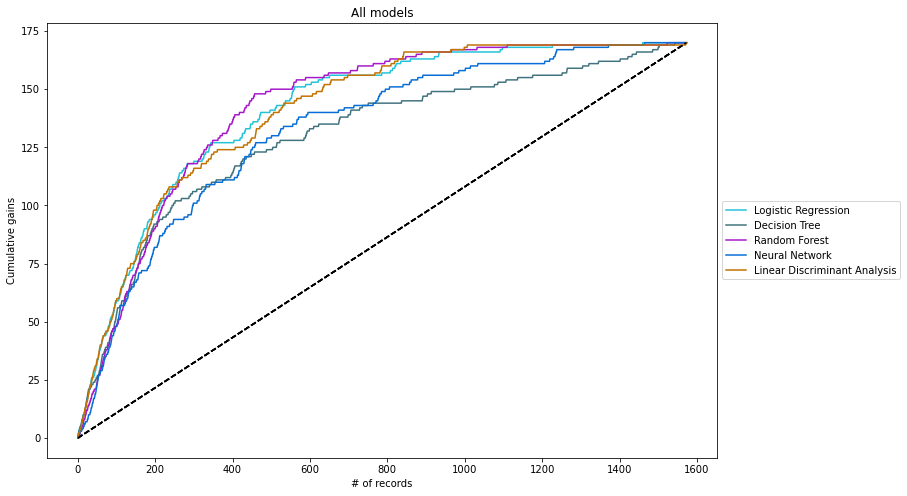

In [40]:
def modelGainsChart(model, title, ax=None):
    
    
    result = pd.DataFrame({
        'actual': y_valid,  # use validate set
        'prob': model.predict_proba(X_valid)[:, 1]
    })

    result = result.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    
    r = random.random()
    b = random.random()
    g = random.random()
    color = (r, g, b)
    
    ax = gainsChart(result.actual, label = title, ax=ax, figsize=[12, 8], color = color)
    ax.set_title(title)
    
    return ax



ax = modelGainsChart(LR, 'Logistic Regression')
modelGainsChart(DT, 'Decision Tree', ax)
modelGainsChart(RF, 'Random Forest', ax)
modelGainsChart(NN, 'Neural Network', ax)
modelGainsChart(LDA, 'Linear Discriminant Analysis', ax)

ax.set_title('All models')
ax.set_xlabel('# of records')
ax.set_ylabel('Cumulative gains')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### ROC Curve

<Figure size 432x288 with 0 Axes>

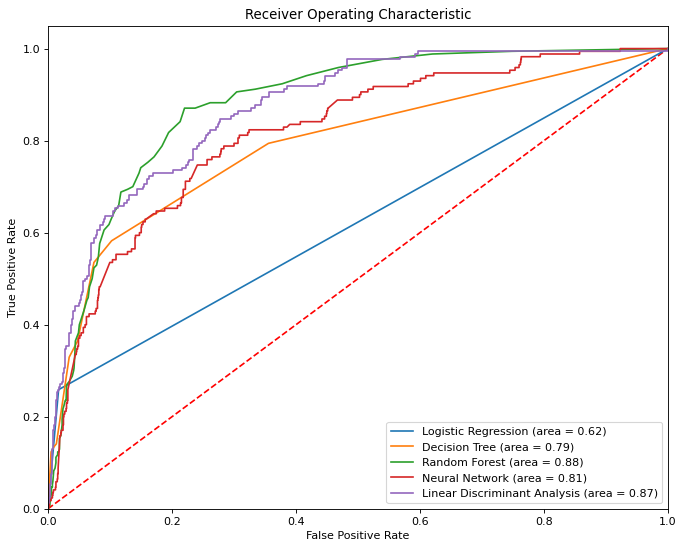

In [41]:
from sklearn import metrics
from matplotlib.pyplot import figure
from sklearn.metrics import roc_curve, roc_auc_score

# DT
probs_dt = DT.predict_proba(X_valid)
preds_dt = probs_dt[:,1]


# RF
probs_rf = RF.predict_proba(X_valid)
preds_rf = probs_rf[:,1]

# NN
probs_nn = NN.predict_proba(X_valid)
preds_nn = probs_nn[:,1]

# LDA
probs_lda = LDA.predict_proba(X_valid)
preds_lda = probs_lda[:,1]


fpr1, tpr1, threshold1 = roc_curve(y_valid, LR.predict(X_valid))
fpr2, tpr2, threshold2 = metrics.roc_curve(y_valid, preds_dt)
fpr3, tpr3, threshold3 = metrics.roc_curve(y_valid, preds_rf)
fpr4, tpr4, threshold4 = metrics.roc_curve(y_valid, preds_nn)
fpr5, tpr5, threshold5 = metrics.roc_curve(y_valid, preds_lda)


lr_roc_auc = metrics.auc(fpr1, tpr1)
dt_roc_auc = metrics.auc(fpr2, tpr2)
rf_roc_auc = metrics.auc(fpr3, tpr3)
nn_roc_auc = metrics.auc(fpr4, tpr4)
lda_roc_auc = metrics.auc(fpr5, tpr5)


plt.figure()
figure(figsize=(10, 8), dpi=80)
plt.plot([0, 1], [0, 1],'r--')


plt.plot(fpr1, tpr1, label='Logistic Regression (area = %0.2f)' % lr_roc_auc)
plt.plot(fpr2, tpr2, label = 'Decision Tree (area = %0.2f)' % dt_roc_auc)
plt.plot(fpr3, tpr3, label = 'Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(fpr4, tpr4, label = 'Neural Network (area = %0.2f)' % nn_roc_auc)
plt.plot(fpr5, tpr5, label = 'Linear Discriminant Analysis (area = %0.2f)' % lda_roc_auc)




plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()